# <b>Predicting Whether a Patient Has Heart Disease Using KNN Classification <3 </b>

### <b>Introduction</b>

Heart disease is a medical condition that affects multitudes of people worldwide; for the past number of years, it has been the leading cause of death (Shouman et al., 2012). There are various factors that can contribute to the risk of heart disease such as age, blood pressure, and cholesterol. However, it is difficult to determine which are the greatest contributing factors that cause heart disease, thus modeling data is a great way to make better predictions that can be applied to patients at risk.

Testing and treating heart disease can be a long, expensive, and sometimes invasive process (Bonow & Braunwald, 2012). As a human, it is difficult to look at someone's statistics and directly determine whether or not they have heart disease. Therefore, it would be beneficial for the medical field and people at risk of heart disease if there was a model or system that provided an easier and quicker way of determining who is likely to be at risk. For that reason, our question for our project is: <b>Can we find which variables correlate most to presence of heart disease, and then use them to create an effective classification model that predicts heart disease in patients?</b>

The dataset used is the UCI Heart Disease Dataset for Cleveland. Statistical information was gathered on 303 different patients in Cleveland, with the goal of ultimately being able to use the gathered variables to predict the presence of heart disease. The variables that were included are found in the following table:

    Table 1: Variable descriptions for UCI Heart Disease Dataset

|Variable|Description|Type|
|-|-|-|
|age|age of patient|numerical|
|sex|sex of patient|categorical|
|sp|chest pain type|categorical|
|trestbps|resting blood pressure in mm Hg|numerical|
|chol|serum cholesterol in mg/dl|numerical|
|fbs|fasting blood pressure > 120 mg/dl|categorical|
|restecg|resting electrocardiographic results|categorical|
|thalach|maximum heart rate achieved|numerical|
|exang|exercise induced angina|categorical|
|oldpeak|ST depression induced by exercise relative to rest|numerical|
|slope|slope of the peak exercise ST segment|categorical|
|ca|number of major vessels|categorical|
|thal|thaalassemia|categorical|
|num|diagnosis of heart disease|categorical|

### <b>Methods and Results</b>

<u>Loading and Wrangling Data</u>

To perform our analysis, we first set the seed and loaded the necessary libraries in order to load, clean, visualize, and model our data. 

In [2]:
seed <- 221

library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
library(ggplot2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

When loading the UCI Heart Disease Dataset for Cleveland, we omitted the rows that included NA values so that R could freely perform calculations on the data without the possibility of returning NA as a result. Additionally, since only 6 out of 303 rows contained NA values, we thought that removing it would have insignificant consequences, if any, in predicting the outcome. We also modified each column to give them appropriate names and data types.

In [3]:
set.seed(seed)

cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) %>%
    rename("age" = X1,
          "sex" = X2,
          "cp" = X3, 
          "trestbps" = X4,
          "chol" = X5, 
          "fbs" = X6,
          "restecg" = X7, 
          "thalach" = X8,
          "exang" = X9,
          "oldpeak" = X10,
          "slope" = X11,
          "ca" = X12,
          "thal" = X13,
          "num" = X14) %>%
    mutate(ca = as.double(ca),
           thal = as.double(thal),
           sex = as_factor(sex),
           num = as_factor(num),
           cp = as_factor(cp),
           fbs = as_factor(fbs),
           restecg = as_factor(restecg),
           exang = as_factor(exang),
           slope = as_factor(slope),
           ca = as.integer(ca),
           thal = as_factor(thal)) %>%
    na.omit()

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.double(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.double(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


We noticed that the number of observations for each individual level of diagnosis of heart disease (1-4) was minimal compared to the recordings of no heart disease (0), as shown in the table below.

In [4]:
set.seed(seed)

cleveland_data %>% 
    group_by(num) %>% 
    summarize(count = n( ))

print("Table 2: Distribution of observations across num")

`summarise()` ungrouping output (override with `.groups` argument)



num,count
<fct>,<int>
0,160
1,54
2,35
3,35
4,13


[1] "Table 2: Distribution of observations across num"


Additionally, the dataset mentions that its purpose is more focused on being used to determine whether or not a patient has heart disease rather than gauging the level of heart disease diagnosis. As a result, we decided to create a new column that shows only whether a patient has heart disease or not, and center our classification model around predicting that.

In [5]:
set.seed(seed)

cleveland_data <- cleveland_data %>%
       mutate(hasdisease = as_factor(num != 0))

head(cleveland_data, 10)
print("Table 3: Visualization of the first 10 rows of our dataset")

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hasdisease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0,FALSE
62,0,4,140,268,0,2,160,0,3.6,3,2,3,3,TRUE
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0,FALSE
63,1,4,130,254,0,2,147,0,1.4,2,1,7,2,TRUE


[1] "Table 3: Visualization of the first 10 rows of our dataset"


Now, our two categories have roughly equal numbers of observations as shown in the table below, and we don’t have to upsample our data. 

In [6]:
set.seed(seed)

cleveland_data %>% 
    group_by(hasdisease) %>% 
    summarize(count = n( ))

print("Table 4: Distribution of observations across hasdisease")

`summarise()` ungrouping output (override with `.groups` argument)



hasdisease,count
<fct>,<int>
FALSE,160
TRUE,137


[1] "Table 3: Distribution of observations across hasdisease"


We then split the data into a training set and testing set to be able to create our classification model, and test its accuracy. The data set was split so that 75% was training and 25% was testing, because we wanted to use a larger training set to have more data to create a more accurate model.  In addition, 75/25 is a common split in the industry. After the split, the training set contains 223 observations and the testing set contains 74 observations.

In [7]:
set.seed(seed)

heart_disease_split <- initial_split(cleveland_data, prop = 0.75, strata = hasdisease)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

<u>Exploring Our Variables</u>

When evaluating which variables have the greatest contribution to heart disease, we focused on the five numeric type variables: age, trestbps, chol, thalach, and oldpeak. We chose to focus on numeric variables over categorical ones because numeric variables can be nicely compared when searching for the K nearest neighbours, and can also be better represented by visuals. For example, if we graph a scatter plot using categorical variables, the points would be plotted in awkward columns or rows on the axis corresponding to specific categories.

To find which two of the five variables had the best correlations for heart disease, we plotted a single variable histogram for each variable in order to view the distribution of positive and negative heart disease diagnoses across a specific variable. Our goal is to find separation of positive and negative diagnoses across the plot of a variable, with one end of the variable being primarily one diagnosis and the other end being the counterpart. The reason we want to see a separation in our histograms is because separation indicates that the variable has a direct relationship with heart disease, ultimately meaning that it will be a good predictor for our classification model.

To our surprise, we found that resting blood pressure (trestbps) and cholesterol (chol) had little to no separation; two variables which we first hypothesized to have a strong correlation with heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



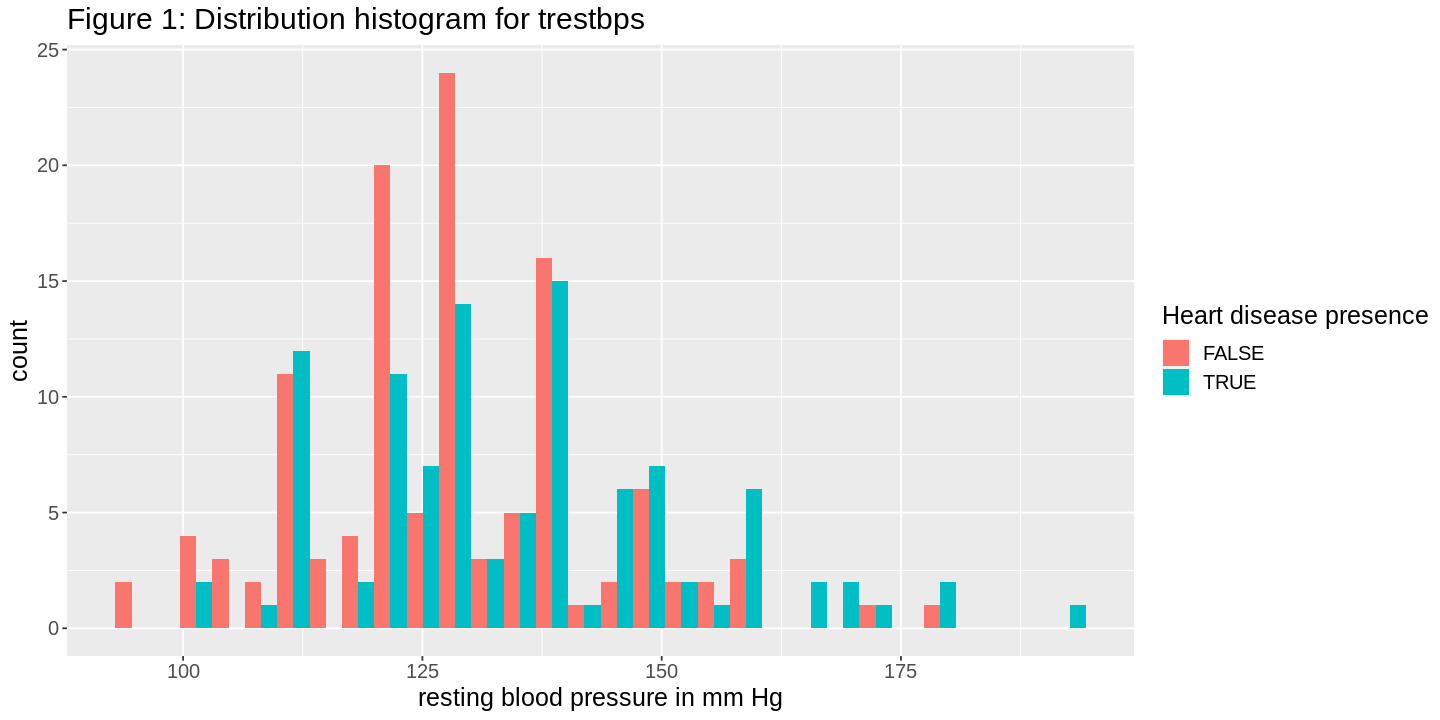

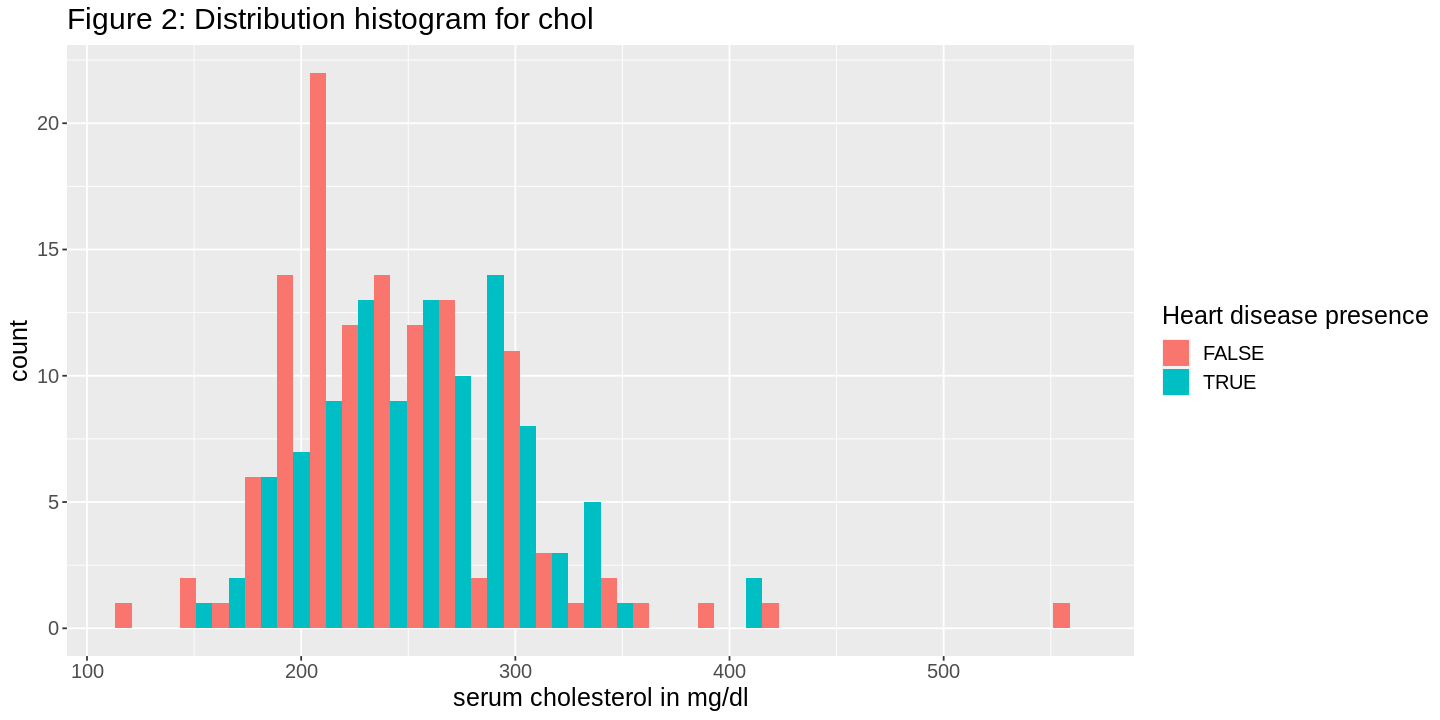

In [8]:
set.seed(seed)

options(repr.plot.width = 12, repr.plot.height = 6)

trestbps_plot <- ggplot(heart_disease_train, aes(x = trestbps, fill = hasdisease)) +
    geom_histogram(position = "dodge") +
    labs(x = "resting blood pressure in mm Hg", fill = "Heart disease presence", title = "Figure 1: Distribution histogram for trestbps") +
    theme(text = element_text(size = 15))

chol_plot <- ggplot(heart_disease_train, aes(x = chol, fill = hasdisease)) +
    geom_histogram(position = "dodge") +
    labs(x = "serum cholesterol in mg/dl", fill = "Heart disease presence", title = "Figure 2: Distribution histogram for chol") +
    theme(text = element_text(size = 15))

trestbps_plot
chol_plot

Some separation was found in our histogram for ST depression induced by exercise (oldpeak).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



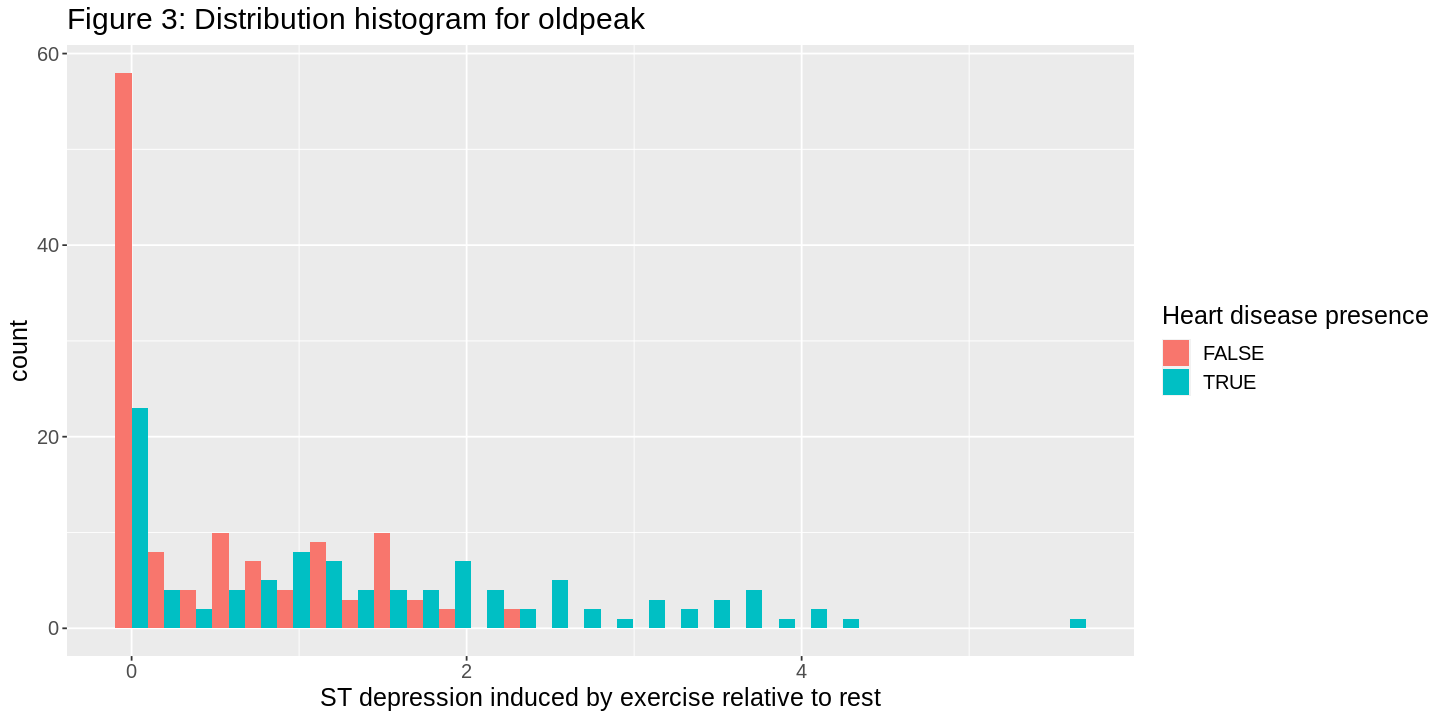

In [20]:
set.seed(seed)

options(repr.plot.width = 12, repr.plot.height = 6)

oldpeak_plot <- ggplot(heart_disease_train, aes(x = oldpeak, fill = hasdisease)) +
    geom_histogram(position = "dodge") +
    labs(x = "ST depression induced by exercise relative to rest", fill = "Heart disease presence", title = "Figure 3: Distribution histogram for oldpeak") +
    theme(text = element_text(size = 15))

oldpeak_plot

However, the two variables which we found to have the greatest distinct separation were maximum heart rate (thalach) and age. Thus, we determined that these two variables would be the best predictors to select for our classification model. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



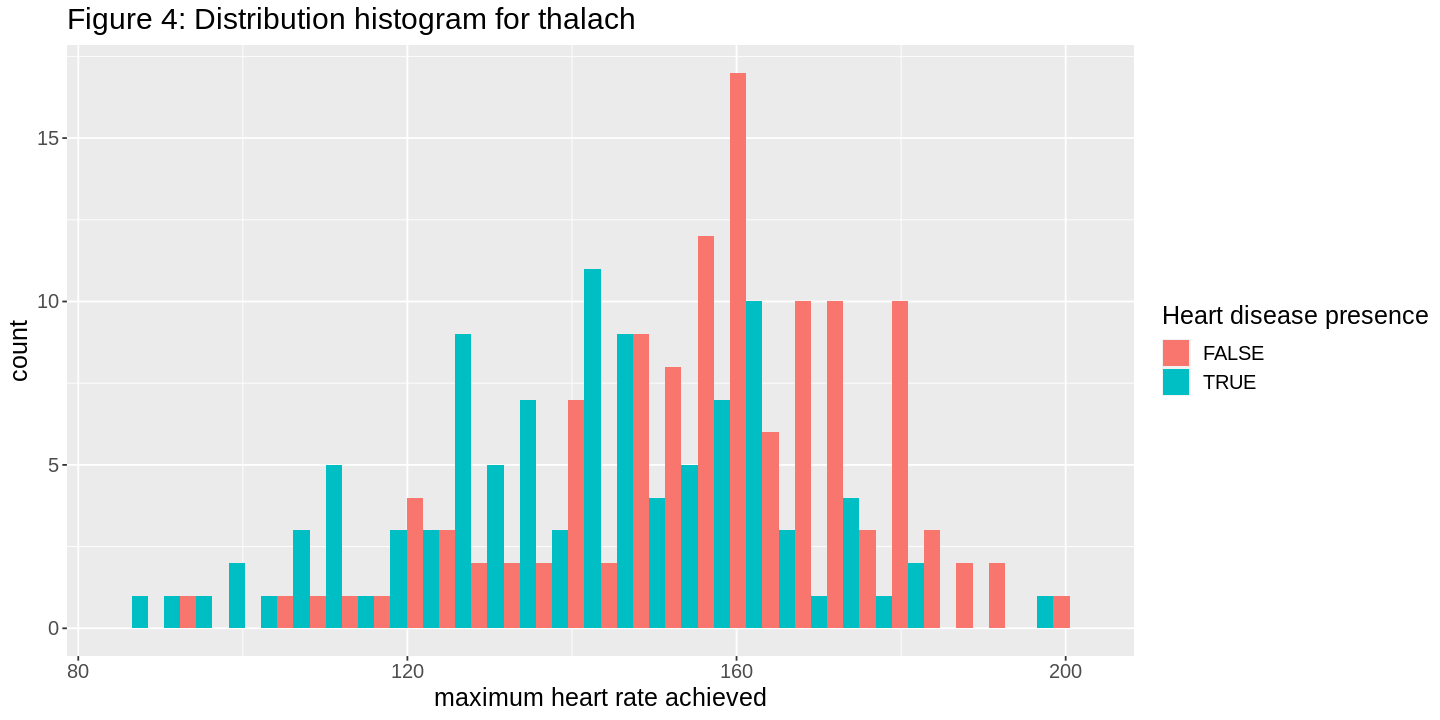

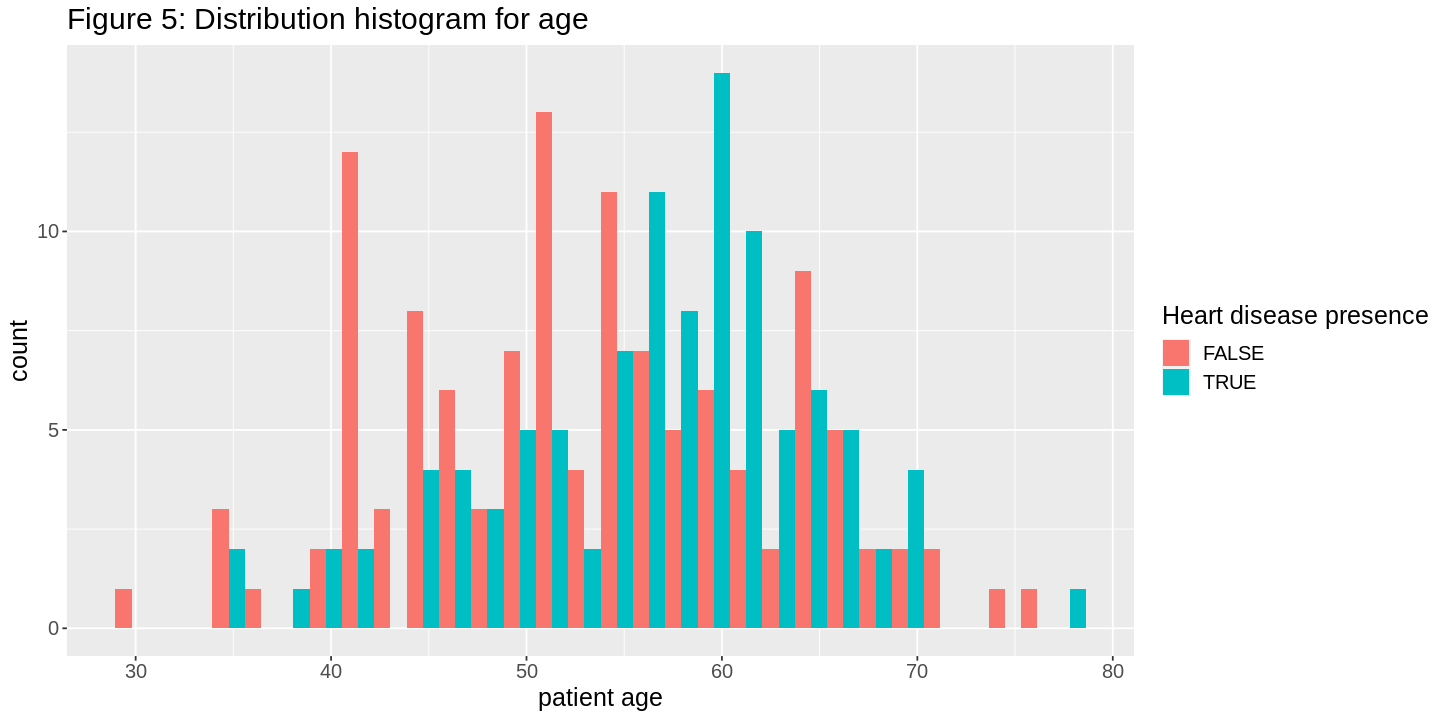

In [10]:
set.seed(seed)

options(repr.plot.width = 12, repr.plot.height = 6)

thalach_plot <- ggplot(heart_disease_train, aes(x = thalach, fill = hasdisease)) +
    geom_histogram(position = "dodge") +
    labs(x = "maximum heart rate achieved", fill = "Heart disease presence", title = "Figure 4: Distribution histogram for thalach") +
    theme(text = element_text(size = 15))

age_plot <- ggplot(heart_disease_train, aes(x = age, fill = hasdisease)) +
    geom_histogram(position = "dodge") +
    labs(x = "patient age", fill = "Heart disease presence", title = "Figure 5: Distribution histogram for age") +
    theme(text = element_text(size = 15))

thalach_plot
age_plot

To verify this, we then plotted a scatterplot with thalach against age, and colour coded the points by presence of heart disease. Our graph showed a slight up/down and left/right separation between positive and negative diagnoses, where negative points trended more towards the top left and positive points trended more towards the bottom right of the plot. That being said, there was the presence of some overlap, especially near the center.

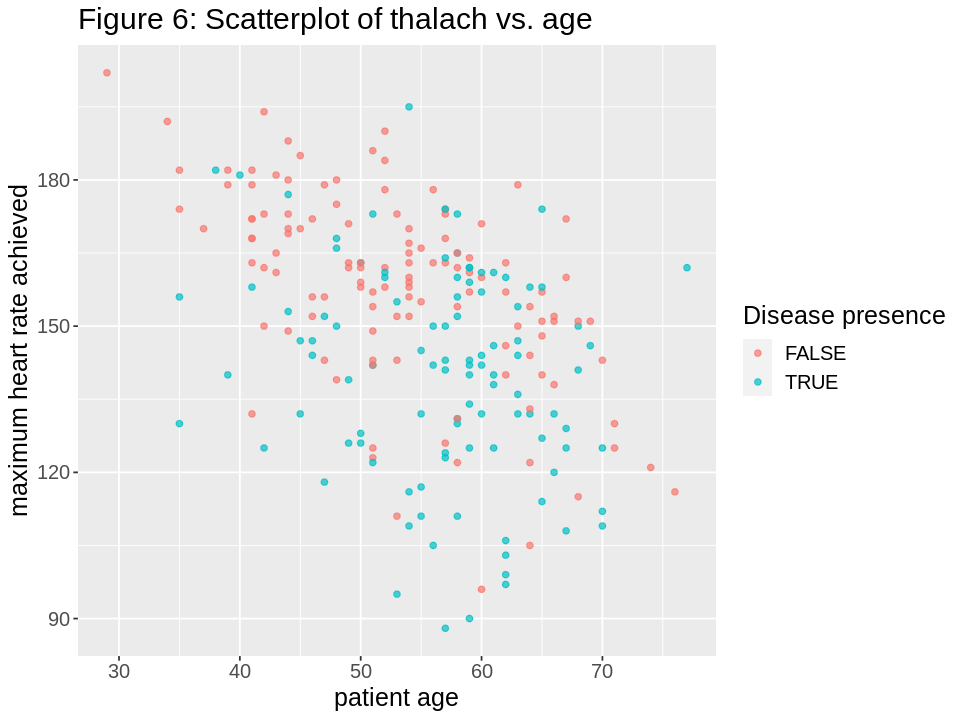

In [11]:
set.seed(seed)

options(repr.plot.width = 8, repr.plot.height = 6)

thalach_vs_age <- heart_disease_train %>%
    ggplot(aes(x = age, y = thalach, colour = hasdisease)) +
    geom_point(alpha = 0.7) +
    labs(x = "patient age", y = "maximum heart rate achieved", colour = "Disease presence", title = "Figure 6: Scatterplot of thalach vs. age") +
    theme(text = element_text(size = 15))

thalach_vs_age

<u>Finding the Optimal Number of Neighbours</u>

Using the training set, we used the vfold_cv function so that we could split the training sets into 5 folds. We stratify the data by disease presence in order to ensure the same ratio of true and false diagnoses in each fold. We chose to do 5 folds because 5 is generally considered the industry standard for a data set of our size.

In [12]:
set.seed(seed)

vfold <- vfold_cv(heart_disease_train, v = 5, strata = hasdisease)

Afterwards, we centered and scaled our predictor variables that we used for the KNN classification, making the mean for both age and thalach equal to 0 and the standard deviation equal to 1. The variables needed to be standardized because they have different magnitudes; average age being around 50, while average thalach was around 150. If our variables were not scaled, the model would have a slight bias towards thalach when comparing how near the neighbouring points are. By scaling, it ensures that the model accounts for both variables equally when calculating the K nearest neighbours.

In [13]:
set.seed(seed)

heart_disease_recipe <- recipe(hasdisease ~ age + thalach, data = heart_disease_train) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

We first need to determine which K value produces the best accuracy, so we set the neighbors parameter in our nearest_neighbor function to be able to tune() in order to produce accuracy estimates for an array of K values.

In [14]:
set.seed(seed)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

In our tune_grid function, we chose to test K values from 1 to 100. We now confirm that testing up to a K value of 100 is sufficiently high because as we can later see in the figure below, the model begins to underfit at such high K values and therefore testing any higher would not yield useful results.

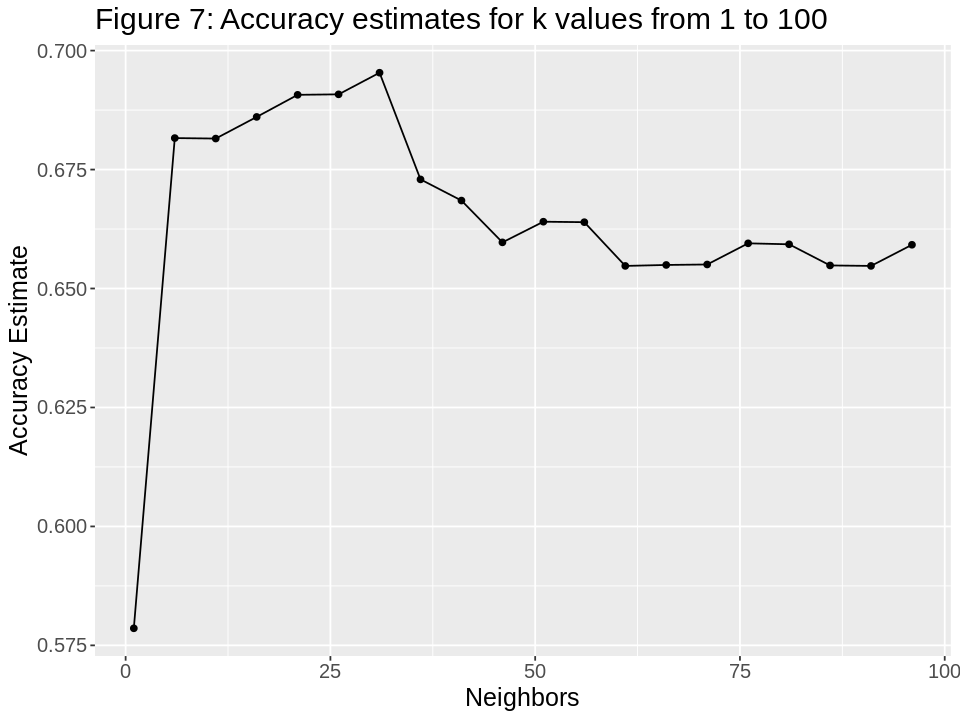

In [15]:
set.seed(seed)

knn_results <- workflow() %>%
    add_recipe(heart_disease_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = vfold, grid = tibble(neighbors = seq(from = 1, to = 100, by = 5))) %>%
    collect_metrics()

accuracies <- knn_results %>%
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Figure 7: Accuracy estimates for k values from 1 to 100") +
    theme(text = element_text(size = 15))

accuracy_vs_k

Looking at the accuracy estimate vs. neighbours visualization, we were able to determine the K value of 25 would be the best pick to optimize our accuracy. The way we chose K was by looking for a K value with a high accuracy estimate, but also no sharp drop off of accuracy estimate within its immediate neighbours.

<u>Making and Testing our Classifier </u>

After creating our model specification with K = 25, we fit it to our training data.

In [16]:
set.seed(seed)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow() %>%
    add_recipe(heart_disease_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = heart_disease_train)

Then, we used the model to make predictions on the testing dataset, and used the metrics function to look at our prediction accuracy.

In [19]:
set.seed(seed)

heart_disease_test_predictions <- predict(knn_fit, heart_disease_test) %>%
    bind_cols(heart_disease_test)

heart_disease_test_accuracy <- heart_disease_test_predictions %>%
    metrics(truth = hasdisease, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

heart_disease_test_accuracy
print("Table 5: Accuracy of our model on the testing data set")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7702703


[1] "Table 5: Accuracy of our model on the testing data set"


 Lastly, we created a confusion matrix for our predictions, as well as a bar chart visualization of our confusion matrix.

[1] "Figure 8: Confusion matrix for model predictions"


          Truth
Prediction FALSE TRUE
     FALSE    33   10
     TRUE      7   24

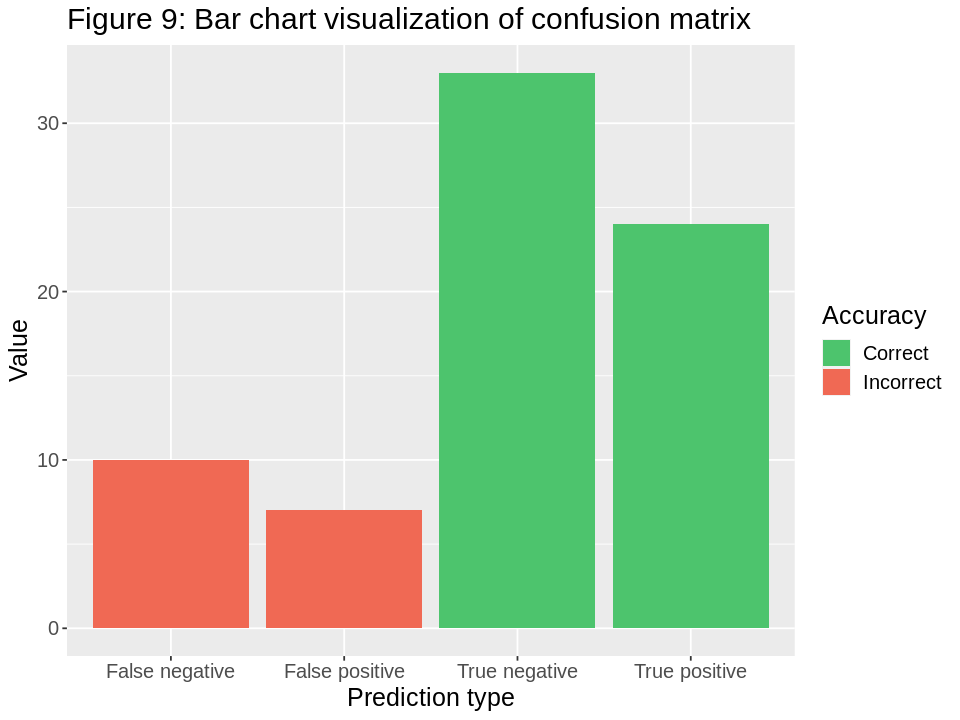

In [18]:
print("Figure 8: Confusion matrix for model predictions")

heart_disease_test_predictions %>% 
    conf_mat(truth = hasdisease, estimate = .pred_class)

matrix_tibble <- tibble(c("True positive", "True negative", "False positive", "False negative"),
                        c(24, 33, 7, 10),
                        c("Correct", "Correct", "Incorrect", "Incorrect"))

colnames(matrix_tibble) <- c("Prediction", "Value", "Accuracy")

matrix_plot <- ggplot(matrix_tibble, aes(x = Prediction, y = Value, fill = Accuracy)) +
    geom_bar(stat = "identity") +
    labs(x = "Prediction type", y = "Value", fill = "Accuracy", title = "Figure 9: Bar chart visualization of confusion matrix") +
    scale_fill_manual(values = c("#4dc46d", "#f06954")) +
    theme(text = element_text(size = 15))

matrix_plot

### <b>Discussion</b>

Our KNN classification model returned an accuracy of roughly 77% when we used it to predict observations in the testing set. We confirm that our model is at least somewhat of an improvement by comparing its accuracy to the majority classifier, which always guesses the majority class regardless of the predictors. In our case, the majority classifier has an accuracy of roughly 54%, so 77% from our model does show noticeable improvement. An accuracy of 77% is acceptable in some scenarios, such as a model for an adblocker only being able to identify and block out 77% of advertisements. The 23% of advertisements that manage to slip through would only cause a slight annoyance to the user, but there would be no serious consequences. However, for our intended purpose, a 77% prediction accuracy is not high enough to be helpful, as heart disease is almost always a life-threatening issue where there is often little room for error. Falsely predicting that a patient does have heart disease is less serious, but falsely predicting that a patient does not have heart disease would be detrimental as a patient would likely not receive the necessary medical attention that is needed. Of the 23% incorrect predictions from our model on the testing set, 14% of them are false negatives (serious), which is simply too high to be used in a situation such as predicting heart disease.

Although this model should not be used in real life to predict whether a patient is at risk for heart disease or not, this model is useful to confirm that there is some positive correlation between presence of heart disease and the variables of age and maximum heart rate achieved. Thus with this information, patients who are older or patients who have a low maximum heart rate could take this into account and be more aware of symptoms and signs of heart disease as they are shown to be more at risk. Perhaps patients who fall into this high risk category should regularly go for check ups with their doctor. That being said, correlation doesn’t always mean causation, and it is important not to use this information to make incorrect assumptions.

As we initially expected the results to have a mediocre accuracy, the results were within our expectations. When initially analyzing histograms of each of the five numerical variables, we looked for any distinct separation of patients with heart disease and patients without heart disease within the visualizations. Because there were significant overlaps in all five histograms we observed, we did not have high expectations for our final result’s accuracy. Additionally, from analyzing the scatterplot of our two best predictor variables, thalach vs age, we could not find any strong trends within the graph. There was at best a slight separation of positive and negative points, suggesting that the classification would have moderate accuracy. 

It is important to note as well that because our training dataset is quite small (229 observations), and the way that the training and testing data happens to be split has a big impact on the final accuracy result. In a way, the accuracy of our model on the testing set depends on if the right data points were “lucky” enough to end up in the testing set and be predicted accurately. If we chose a different seed for the project, we would likely get an accuracy with a noticeable difference.

We could improve our project potentially by finding a data set with a larger number of observations. Increasing our data set size would allow us to have more data to base our predictions off of. Thus, the accuracy of our predictions would likely increase. Another potential improvement of our project could be to expand our data set to include observations from other regions of the world. There are likely geographical and ethnic factors that contribute to one's susceptibility to heart disease, so having data points from around the world would allow us to create different classification models for different regions around the world, allowing its usability to be applicable to a wider range of patients.

We decided to use two predictor variables because it allowed us to create intuitive 2 dimensional visualizations. However, this proposes the question, would using a different number of predictor variables lead to a better classification model? Another question that we have is if there is a way in which we could have incorporated the categorical variables in some way. For example, maybe there is a difference in which variables most affect heart disease between men and women. If there was, could we have potentially created two models with different predictors; one for men and one for women?

 Reflecting on our accuracy of only 77% after our best efforts, it made us think that perhaps KNN classification is not the best approach to create a model for this specific scenario. This then proposes another question, would we be able to create a better model using a different approach? Perhaps we could continue to self study more types of classification models moving forward, and find one that is more applicable to our situation.


### <b> References </b>

Bonow, R. O., & Braunwald, E. (2012). Heart disease: A textbook of cardiovascular medicine (12th ed.). Elsevier / Saunders. 

Shouman, Mai et. al. (2012). Applying k-Nearest Neighbour in Diagnosing Heart Disease
Patients. International Conference on Knowledge Discovery, 20. 
